In [1]:
import fastai
from fastai.vision.all import *
from fastai.vision.gan import generate_noise
from fastdownload import FastDownload
import matplotlib.pyplot as plt
from models.GAN import Generator, Discriminator, GANLearner
from torchsummary import summary

In [2]:
path = Path('./data')

In [3]:
Path.BASE_PATH = path

In [4]:
if not (path/'archive').exists():
    loader = FastDownload(base=path.name, module=fastai.data)
    loader.update('https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/camel.npy')
    loader.download('https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/camel.npy')

In [5]:
def get_quickdraw_tensors(path):
    files = get_files(path, extensions=['.npy'])
    i = 0
    
    for f in files:
        subject = torch.from_numpy(np.load(f))
        subject = subject.view(subject.shape[0], 1, 28, 28)
        
        if i == 0:
            x = subject
        else:
            x = torch.cat((x, subject))
        
        i += 1
    
    return x

In [6]:
generator = Generator(z_dim=100,
                      unflattened_shape=[64, 7, 7],
                      upsample_scale=[2, 2, 1, 1],
                      filters=[128, 64, 64, 1],
                      kernels=[5, 5, 5, 5],
                      strides=[1, 1, 1, 1],
                      batch_norm_mom=0.9,
                      dropout_prob=None
                     )

discriminator = Discriminator(input_shape=[1, 28, 28],
                              filters=[64, 64, 128, 128],
                              kernels=[5, 5, 5, 5],
                              strides=[2, 2, 2, 1],
                              batch_norm_mom=None,
                              dropout_prob=0.4
                             )

In [ ]:
summary(discriminator, (1, 28, 28))

In [ ]:
summary(generator, (100,))

In [7]:
def gen_loss_func(disc_pred):
    loss = nn.BCELoss()
    target = torch.ones_like(disc_pred).to(default_device())
    output = loss(disc_pred, target)
          
    return output

In [8]:
def disc_loss_func(fake_pred, real_pred):
    loss = nn.BCELoss()
    device = default_device()
    fake_target = torch.zeros_like(fake_pred).to(device)
    real_target = torch.ones_like(real_pred).to(device)
    output = loss(fake_pred, fake_target) + loss(real_pred, real_target)
    
    return output

In [9]:
def create_tensor_image(tensor):
    return TensorImage(tensor)

In [10]:
datablock = DataBlock(blocks=(TransformBlock, TransformBlock(type_tfms=create_tensor_image)),
                      get_items=get_quickdraw_tensors,
                      get_x=generate_noise,
                      splitter = RandomSplitter(seed=42),
                      batch_tfms = L(IntToFloatTensor,
                                     Normalize.from_stats(torch.tensor([0.5]), torch.tensor([0.5]))
                                    )
                     )

In [11]:
dataloaders = datablock.dataloaders(path, bs=128)

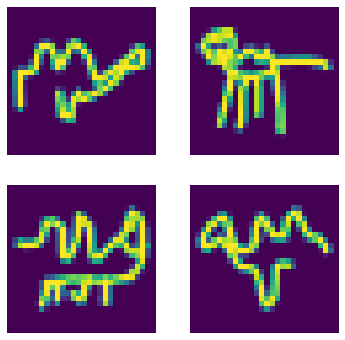

In [12]:
dataloaders.show_batch(max_n=4)

In [13]:
learner = GANLearner(dataloaders=dataloaders,
                     generator=generator,
                     discriminator=discriminator,
                     gen_loss_func=gen_loss_func,
                     disc_loss_func=disc_loss_func,
                     opt_func=RMSProp
                    )

# Since the validation loss is the same as the generator loss, don't display it
learner.recorder.train_metrics = True
learner.recorder.valid_metrics = False

In [14]:
learner.fit(50, 2e-4)

epoch,train_loss,gen_loss,disc_loss,time
0,1.040339,0.692990,1.387844,00:24
1,1.066056,0.731766,1.377409,00:23
2,1.093596,0.788578,1.362921,00:23
3,1.109877,0.851922,1.350405,00:23
4,1.149437,0.925765,1.334460,00:23
5,1.169495,0.991039,1.321066,00:23
6,1.182419,1.028081,1.310565,00:23
7,1.175810,1.062383,1.301014,00:23
8,1.177073,1.055606,1.297718,00:23
9,1.180279,1.062589,1.294201,00:23
